In [1]:
from sqlalchemy import or_, func
from sqlalchemy.orm import sessionmaker
from HardwareSwap.Models import Base, engine, Post, PostType, get_or_create, Series, Manufacturer, Brand, GPU, PostBrand, PostManufacturer, Item, ItemType
import tqdm

In [2]:
recreate = False
if recreate:
    Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)
Session = sessionmaker(bind = engine)

In [3]:
s = Session()
buying = get_or_create(s, PostType, post_type="buying")
selling = get_or_create(s, PostType, post_type="selling")
trading = get_or_create(s, PostType, post_type="trading")
giveaway = get_or_create(s, PostType, post_type="giveaway")
meta = get_or_create(s, PostType, post_type="meta")
official = get_or_create(s, PostType, post_type="official")
alert = get_or_create(s, PostType, post_type="alert")

In [4]:
%load_ext autoreload
%autoreload 1
%aimport HardwareSwap
%aimport HardwareSwap.DownloadData
%aimport HardwareSwap.DownloadData.download_data
from HardwareSwap.DownloadData import download_data, remove_duplicate_rows
import os
import datetime
import pytz
import pandas as pd
from HardwareSwap.Models.Post import get_regex_to_parse_title
import re
import json
import matplotlib.pyplot as plt

In [22]:
data_root = "/home/neil/hardwareswap/raw_data/"
pcpartpicker_gpu_dir = os.path.join(data_root, "pcpartpicker_gpu")
raw_data = download_data.load_dataframe_from_disk(os.path.join(data_root, "reddit_posts", "data_*-*.json"), limit=1000)

print(f"Found {len(raw_data)} posts")
Post.create_bulk(raw_data, s)
Post.clean(s)

Found 99697 posts


100%|██████████| 89680/89680 [00:45<00:00, 1986.37it/s]


Inserting 89680 items... Done!


In [23]:

pcpartpicker_gpus_fname = os.path.join(pcpartpicker_gpu_dir, "pcpartpicker_gpu.json")
if os.path.isfile(pcpartpicker_gpus_fname):
    with open(pcpartpicker_gpus_fname, 'r') as fp:
        gpus_all = json.load(fp)

In [24]:
df = pd.DataFrame(gpus_all)
df["chipset"] = df.apply(lambda x: x["chipset"].replace("Chipset",""), axis=1)
df["brand"] = ""
df["mfg"] = ""

# set the brands
df.at[df["chipset"].str.contains("GeForce"), "brand"] = "nvidia"
df.at[df["chipset"].str.contains("Quadro"), "brand"] = "nvidia"
df.at[df["chipset"].str.contains("NVS"), "brand"] = "nvidia"
df.at[df["chipset"].str.contains("RTX"), "brand"] = "nvidia"
df.at[df["chipset"].str.contains("Titan"), "brand"] = "nvidia"
df.at[df["chipset"].str.contains("Radeon"), "brand"] = "amd"
df.at[df["chipset"].str.contains("FirePro"), "brand"] = "amd"
df.at[df["chipset"].str.contains("Vega"), "brand"] = "amd"
df.at[df["chipset"].str.contains("FireGL"), "brand"] = "amd"

# manufacture
brands = ["Sapphire","Asus","Gigabyte","EVGA","MSI","PNY","Zotac", "Lenovo", "GALAX","Inno3D","Jaton Video",
          "Galaxy","Sparkle", "ECS","Palit","KFA2" ,"OcUK","Gainward","XFX","BFG","NVIDIA","HP","Leadtek",
          "Zogis","Colorful","Biostar","Corsair","Dell", "HIS", "PowerColor", "VisionTek","Diamond", "Club 3D", "ASRock", "ATI","AMD", "Yeston"]
for brand in brands:
    df.at[df["name"].str.contains(brand), "mfg"] = brand.lower()


# Extract information about the gpus
result_names=["series","prefix","number","variant"]
for col in result_names:
    df[col] = ""
f_geforce = re.compile("(?P<series>(?:GeForce))?\s?(?P<prefix>(?:GTX)|(?:RTX)|(?:GT)|(?:GTS))\s?(?P<number>[123]?[0245679][1-9]0)\s?(?P<variant>(?:Ti|m))?")
f_quadro = re.compile("(?P<series>(?:Quadro))?\s?(?P<prefix>[KMP])\s?(?P<number>[12345678][02]0{2})\s?(?P<variant>(?:D))?")
f_titan = re.compile("(?P<series>(?:GeForce))?\s?(?P<prefix>(?:GTX)|(?:RTX))\s?(?P<number>(?:Titan))\s?(?P<variant>(?:Z)|(?:X)|(?:Black))?")
f_radeon = re.compile("(?P<series>(?:Radeon Pro)|(?:Radeon))\s?(?P<prefix>(?:RX)|(?:R[579])|(?:HD)|(?:WX))?\s?(?P<number>(?:[34567]?[123456789][03456789][05])|(?:Fury)|(?:VEGA [56][46])|(?:Nano)|(?:VII))?\s?(?P<variant>(?:X2)|(?:XT)|(?:X))?")
f_firepro = re.compile("(?P<series>(?:FirePro)|(?:FireGL))\s?(?P<prefix>(?:[VWRS][G]?))?\s?(?P<number>(?:[2345789]?[012346789][02567]0))\s?(?P<variant>(?:A?))?")
f_vega = re.compile("(?P<series>(?:Vega))\s?(?P<prefix>)?\s?(?P<number>)\s?(?P<variant>(?:Frontier Edition Liquid)|(?:Frontier Edition))")

for idx in range(len(df)):
    chipset = df.at[idx, "chipset"]
    for regex_function in [f_geforce, f_quadro, f_titan, f_radeon, f_firepro, f_vega]:
        match = regex_function.match(chipset)
        if match is None:
            continue
        series,prefix,number,variant = match.group(*result_names)
        df.at[idx,"series"] = series if not None else ""
        df.at[idx,"prefix"] = prefix if not None else ""
        df.at[idx,"number"] = number if not None else ""
        df.at[idx,"variant"] = variant if not None else ""
        break

#df[(df["brand"]=="nvidia") & (df["model"]=="")]
df[(df["brand"]=="amd" ) & (df["number"]=="")]


,name,chipset,price,url,brand,mfg,series,prefix,number,variant
3376,AMD 100-506061,Vega Frontier Edition,1750.00,/product/mCH48d/amd-vega-frontier-edition-air-...,amd,amd,Vega,,,Frontier Edition
4218,AMD 100-506062,Vega Frontier Edition Liquid,0,/product/8QrcCJ/amd-vega-frontier-edition-liqu...,amd,amd,Vega,,,Frontier Edition Liquid


In [25]:


def geforce_series(row):
    if row["series"] != "GeForce":
        return ""
    if not row["number"].isnumeric():
        return ""
    scale = 100
    series = f"GeForce {int(int(row['number'])/scale)}"
    return series

def get_vendor_series(row):
    if row["series"] == "GeForce":
        return geforce_series(row)

df["Vendor Series"] = df.apply(lambda row: geforce_series(row), axis=1)

series = {}
for item in df["Vendor Series"].unique():
    if item == "":
        continue
    elif item is None:
        continue
    series[item] = get_or_create(s,  Series, series=item)
    
mfgs = {}
for item in df["mfg"].unique():
    if item == "":
        continue
    elif item is None:
        continue
    mfgs[item] = get_or_create(s,  Manufacturer, manufacturer=item)

brands = {}
for item in df["brand"].unique():
    if item == "":
        continue
    elif item is None:
        continue
        
    brands[item] = get_or_create(s,  Brand, brand=item)

"""
This adds all the gpus found above to the databse, but not sure that we actually want that data


gpus = []
for idx in range(len(df)):
    row = df.iloc[idx]
    price = None
    if row["price"] != "0":
        price = float(row["price"])
    try:
        gpu = GPU(
            name = row["name"],
            brand_id = brands[row["brand"]].id,
            manufacturer_id = mfgs[row["mfg"]].id,
            series_id = series[row["Vendor Series"]].id,
            chipset = row["chipset"],
            prefix = row["prefix"],
            number = int(row["number"]),
            pcpartpicker_url = row["url"],
            pcpartpicker_price = price,       
                )
        gpus.append(gpu)
    except KeyError:
        pass
s.bulk_save_objects(gpus)
s.commit()
"""
None

In [29]:
s.rollback()

In [30]:
item_type_gpu = get_or_create(s, ItemType, item_type="gpu")
brand_nvidia = s.query(Brand).filter(Brand.brand=="nvidia").one()
manufacturers = {item.manufacturer.lower(): item.id for item in s.query(Manufacturer).all()}

In [31]:
f_geforce = re.compile("(?P<mfg>(?:Asus)|(?:Gigabyte)|(?:EVGA)|(?:MS)|(?:PNY)|(?:Zotac)|(?:GALAX)|(?:BFG)|(?:NVIDIA))?\s?"\
                       "(?P<prefix>(?:GTX)|(?:RTX)|(?:GT)|(?:GTS))\s?"\
                       "(?P<number>[123]?[0245679][1-9]0)\s?"\
                       "(?P<variant>(?:Ti|m))?\s?"\
                       "(?P<edition>(?:FE|founder\'?s\sedition))?"\
                       ".{0,100}?"+ # consume as few characters as possible to the first price
                       "(?P<price>\$(?:\d{1,3},?)(?:\d{1,3})(?:\.\d\d)?)" + # Prices must start with '$'. Max price is 999,999.99.  Does not need decimals. Can contain ',' as a thousands separator
                       "(?P<price_external>(?:.{0,100})(?:\@.{0,100}))?", # Try and determine if the detected price is coming from some external source (ie referenceing PC Part Picker)
                      re.IGNORECASE)
f_founders_edition = re.compile("(?:FE|founder\'?s\?sedition)", re.IGNORECASE)

items = []
for post in tqdm.tqdm(
        s.query(Post.id, Post.have, Post.selftext, Post.created_utc)
            #.join(PostManufacturer, Post.id==PostManufacturer.post_id)
            #.join(Manufacturer, PostManufacturer.manufacturer_id==Manufacturer.id)
            #.filter(Manufacturer.manufacturer=="nvidia")
            .filter(Post.post_type_id==2)
            .order_by(Post.created_utc)
            #.limit(2000)
            .all()
        ):
    if post[2] is None:
        continue
    
    items_existing = s.query(Item.id, Item.location_in_post_start, Item.location_in_post_end).filter(Item.post_id=="5ngvid").all()
    
    for match in f_geforce.finditer(post[2]):
        
        # See if match overlaps with any existing items
        # at a later date this could be used to update the existing item
        start = match.start()
        end = match.end()
        found_overlap = False
        for ie in items_existing:
            if (start >= ie[1] & start <= ie[2]) | (end >= ie[1] & end <= ie[2]) | (start <= ie[1] &  end >= ie[2]):
                found_overlap = True
                break
        if found_overlap:
            continue
        
        data = match.groupdict()
        
        manufacturer = data["mfg"]
        if manufacturer is not None:
            manufacturer_id = manufacturers.get(data["mfg"].lower())
        else:
            manufacturer_id = None
            
        variant = data["variant"]
        if variant is not None:
            variant = variant.lower()
        
        edition = data["edition"]
        if edition is not None:
            if len(f_founders_edition.findall(edition)) > 0:
                edition = "FE"
            
        price = float(data["price"].strip("$").replace(",",""))
        
        items.append(
            Item(
                    post_id = post[0],
                    item_type_id = item_type_gpu.id,
                    brand_id = brand_nvidia.id,
                    manufacturer_id = manufacturer_id,
                    number = data["number"],
                    variant = variant,
                    edition = edition,
                    price = price,
                    price_possibly_external = data["price_external"] is not None, 
                    location_in_post_start = match.start(),
                    location_in_post_end = match.end(),
                )
        )
        
    #print("-"*50)
    #if len(matches) == 3:
    #    break
s.bulk_save_objects(items)
s.commit()

100%|██████████| 47967/47967 [00:29<00:00, 1625.57it/s]


In [32]:
items_existing = s.query(Item.id, Item.location_in_post_start, Item.location_in_post_end).filter(Item.post_id=="5ngvid").all()

for item in items_existing:
    print(item)


(218, 518, 540)
(219, 601, 621)


In [38]:
import numpy as np
import matplotlib.pyplot as plt

In [48]:
r = s.query(Post.created_utc,Item.price).join(Post, Post.id==Item.post_id).join(ItemType, ItemType.id==Item.item_type_id).filter(Item.number=="3070").all()

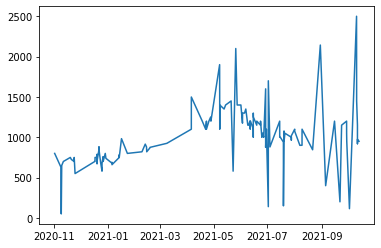

In [49]:
r = np.array(r)
plt.plot(r[:,0], r[:,1])

In [ ]:
cards = pd.DataFrame(matching_posts)
cards.sort_values("created", inplace=True)
cards.reset_index(inplace=True, drop=True)
print(len(cards))

In [ ]:
cards

In [ ]:
cards[cards["number"]=='3080'].groupby(["number","variant", "edition"]).size()

In [ ]:
cards.groupby(["mfg"]).size()

In [ ]:
s.query(Item.id, Item.number).all()

In [ ]:
plt.rcParams["figure.figsize"] = [20,10]
matching_query = cards[(cards["number"]=="2080") & (cards["variant"]=="Ti") & (cards["price_external"]=="")]
#plt.plot(matching_query["created"], matching_query["price"])

matching_query = cards[(cards["number"]=="2080") & (cards["variant"]=="") & (cards["price_external"]=="")]
#plt.plot(matching_query["created"], matching_query["price"])



In [ ]:
matching_query = cards[(cards["number"]=="3070") & (cards["variant"]=="") & (cards["price_external"]=="")]

std = matching_query["price"].std()
mean = matching_query["price"].mean()
price_min = mean - std
price_max = mean + std


matching_query_filtered = matching_query[(matching_query["price"]>=price_min) & (matching_query["price"]<=price_max) ]

print(f"Mean and std used: {mean:.2f} {std:.2f}")
print(f"Mean and std new : {matching_query_filtered['price'].mean():.2f} { matching_query_filtered['price'].std():.2f}")

plt.plot(matching_query["created"], matching_query["price"])
plt.plot(matching_query_filtered["created"], matching_query_filtered["price"])
plt.ylim((0,1500))

In [ ]:
matching_query[(matching_query["price"]>100) & (matching_query["price"]<200) ]# & (matching_query["created"]>datetime.datetime(year=2019, month=7, day=1))]

In [ ]:
print(s.query(Post).get("jypcbl").selftext)

In [ ]:
matching_query[matching_query["post_id"]=="dcyhwu"]

In [54]:
number="1030"
edition=None
variant=None
result = s.query(Post.created_utc, Item.price).join(Item, Item.post_id==Post.id).filter(Item.number==number, Item.variant==variant, Item.edition==edition).order_by(Post.created_utc).all()
np.array(result)

array([[datetime.datetime(2017, 10, 29, 4, 50, 12), 92.0],
       [datetime.datetime(2018, 5, 30, 4, 43, 57), 80.0],
       [datetime.datetime(2018, 9, 15, 17, 39, 6), 240.0],
       [datetime.datetime(2018, 10, 5, 22, 20, 2), 75.0],
       [datetime.datetime(2019, 5, 9, 23, 50, 2), 55.0],
       [datetime.datetime(2019, 6, 17, 4, 16, 31), 60.0],
       [datetime.datetime(2019, 10, 23, 2, 34, 27), 60.0],
       [datetime.datetime(2020, 5, 13, 19, 19, 24), 75.0],
       [datetime.datetime(2020, 7, 28, 5, 2, 18), 70.0],
       [datetime.datetime(2020, 8, 2, 19, 29, 21), 300.0],
       [datetime.datetime(2020, 8, 2, 19, 29, 21), 300.0],
       [datetime.datetime(2020, 11, 30, 18, 16, 46), 65.0],
       [datetime.datetime(2021, 5, 12, 22, 33, 58), 95.0],
       [datetime.datetime(2021, 5, 12, 22, 36, 27), 95.0],
       [datetime.datetime(2021, 5, 27, 21, 55, 59), 95.0],
       [datetime.datetime(2021, 8, 2, 20, 1, 34), 80.0],
       [datetime.datetime(2021, 8, 9, 13, 57, 21), 85.0],
      